# Speech Recognition System

Data: Free Spoken Digit Dataset
https://github.com/Jakobovski/free-spoken-digit-dataset

    4 speakers
    10 digits
    50 recordings of each digit --> 2000 total recording
    We will train the model on three speakers and test the model on 1 speaker to avoid data leakage
    
1. Extracting the labels
2. Exploratory data analysis 
3. Extracting audio features

In [197]:
# Importing all the required libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile
import wave
import IPython.display as ipd
from python_speech_features import mfcc, logfbank
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Input,Dense,Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LSTM, TimeDistributed
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [198]:
!pip install SpeechRecognition
import speech_recognition as sr
!pip install sounddevice
!pip install soundfile
import soundfile as sf
import sounddevice as sd

### Frequently used plot functions

In [199]:

def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Signal in time domain', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Signal in Frequency domain', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

### Dataset analysis

In [200]:
#Extracting labels

digit = []
labels=os.listdir('../Data/')
for label in labels:
    digit.append(label.split('_')[0])
df = pd.DataFrame(digit,labels,columns=['Digit'])
df.head(6)

,Digit
5_nicolas_9.wav,5
3_yweweler_14.wav,3
4_yweweler_38.wav,4
3_yweweler_28.wav,3
4_yweweler_10.wav,4
8_rach_5.wav,8


In [201]:
#Reading the audio file and calculating the length
for f in df.index:
    rate, signal = wavfile.read('../data/'+f)
    df.at[f,'length (sec)'] = signal.shape[0]/rate
    df.at[f,'speaker'] = f.split('_')[1]
df.head(6)

,Digit,length (sec),speaker
5_nicolas_9.wav,5,0.337375,nicolas
3_yweweler_14.wav,3,0.305750,yweweler
4_yweweler_38.wav,4,0.383125,yweweler
3_yweweler_28.wav,3,0.284000,yweweler
4_yweweler_10.wav,4,0.362250,yweweler
8_rach_5.wav,8,2.000000,rach


In [202]:
#Finding the number of recordings for each digit
classes = pd.DataFrame(df.groupby('Digit').count())
classes.rename(columns = {'length (sec)': 'count'})
classes.drop('speaker',axis=1,inplace = True)
classes

,length (sec)
Digit,
0,210
1,210
2,210
3,210
4,210
5,210
6,210
7,210
8,210


In [203]:
#Finding the number of speakers
classes1 = pd.DataFrame(df.groupby('speaker').count())
classes1.drop('Digit',axis=1,inplace = True)
classes1
classes1.rename(columns = {'length (sec)': 'count'})

,count
speaker,
jackson,500
nicolas,500
rach,100
theo,500
yweweler,500


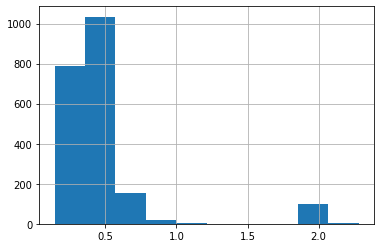

In [204]:
#Duration of the recordings

df['length (sec)'].hist()

# Note: Most of the recordings are less than half a second

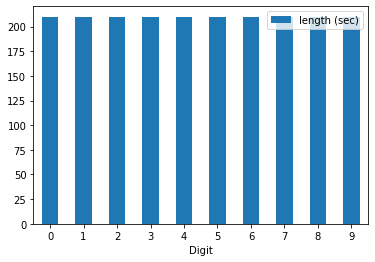

In [205]:
classes.plot.bar(rot = 0)

In [206]:
class_dist = df.groupby(['Digit'])['length (sec)'].mean()
class_dist

Digit
0    0.543734
1    0.450204
2    0.435789
3    0.428216
4    0.442020
5    0.489369
6    0.499733
7    0.488319
8    0.448235
9    0.556947
Name: length (sec), dtype: float64

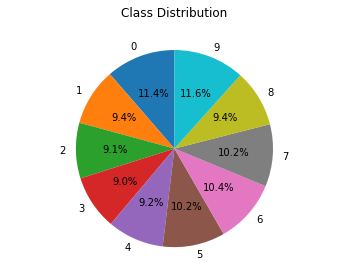

In [207]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y = 1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow = False, startangle=90)
ax.axis('equal')
plt.show()


### Data exploration

In [208]:
#df.drop('level_0',axis=1,inplace=True)
df1 = df
df1 = df1.reset_index()
df1

,index,Digit,length (sec),speaker
0,5_nicolas_9.wav,5,0.337375,nicolas
1,3_yweweler_14.wav,3,0.305750,yweweler
2,4_yweweler_38.wav,4,0.383125,yweweler
3,3_yweweler_28.wav,3,0.284000,yweweler
4,4_yweweler_10.wav,4,0.362250,yweweler
...,...,...,...,...
2095,7_theo_47.wav,7,0.390250,theo
2096,4_yweweler_21.wav,4,0.342500,yweweler
2097,5_nicolas_4.wav,5,0.349750,nicolas
2098,3_yweweler_19.wav,3,0.395625,yweweler


### Function: Calculation fft 

In [209]:
def calculate_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    mag_y = abs(np.fft.rfft(y)/n)  #normalise value by dividing by length
    return mag_y, freq

def getmfcc(y, max_pad_len=40):
    mfcc = librosa.feature.mfcc(y, sr=8000 ,n_mfcc=13)
    pad_width = abs(max_pad_len - mfcc.shape[1])
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

# remove dead spots in the data
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    ymean = y.rolling(window=int(rate/10), min_periods = 1, center = True).mean()
    for mean in ymean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [210]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes.index:
    wav_file = df1[df1.Digit == c].iloc[0,0]
    print(wav_file)
    signal, rate = librosa.load('../Data/'+wav_file,sr = None)
    mask = envelope(signal, rate, 0.001)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calculate_fft(signal, rate)
    
    fbank[c] = logfbank(signal, rate, nfilt=26).T
    #mfccs[c] = mfcc(signal,rate,numcep=13,nfilt=26).T
    mfccs[c] = getmfcc(signal)
    #mfccs[c] = librosa.feature.mfcc(signal, sr=8000 ,n_mfcc=13)

0_theo_46.wav
1_nicolas_15.wav
2_jackson_20.wav
3_yweweler_14.wav
4_yweweler_38.wav
5_nicolas_9.wav
6_jackson_41.wav
7_yweweler_41.wav
8_rach_5.wav
9_jackson_43.wav


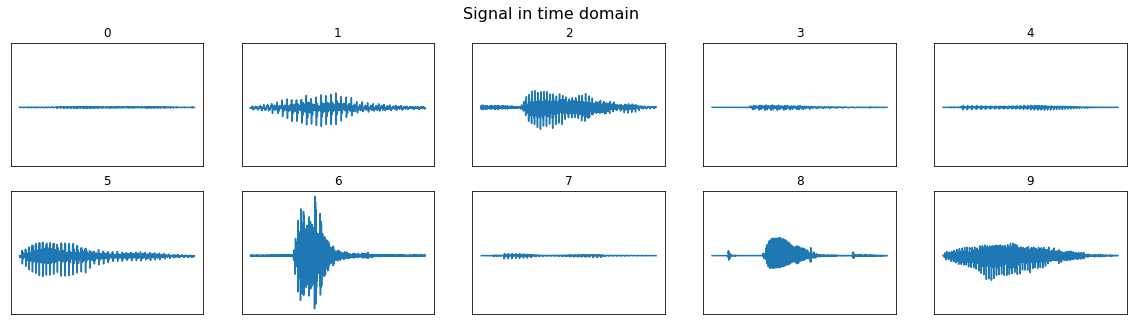

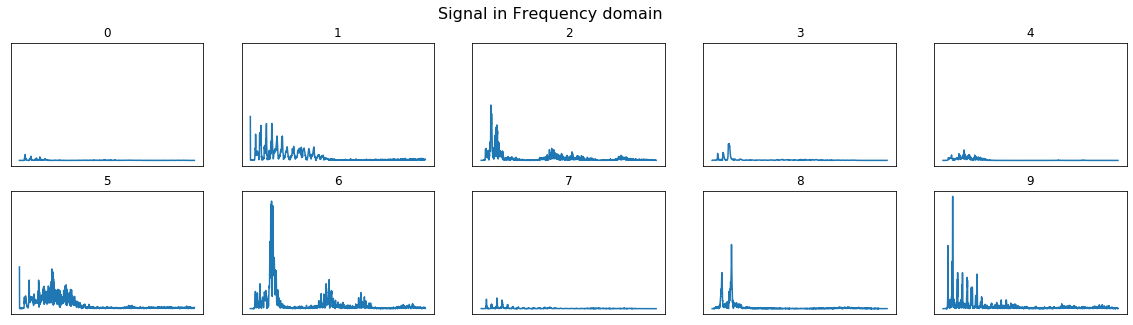

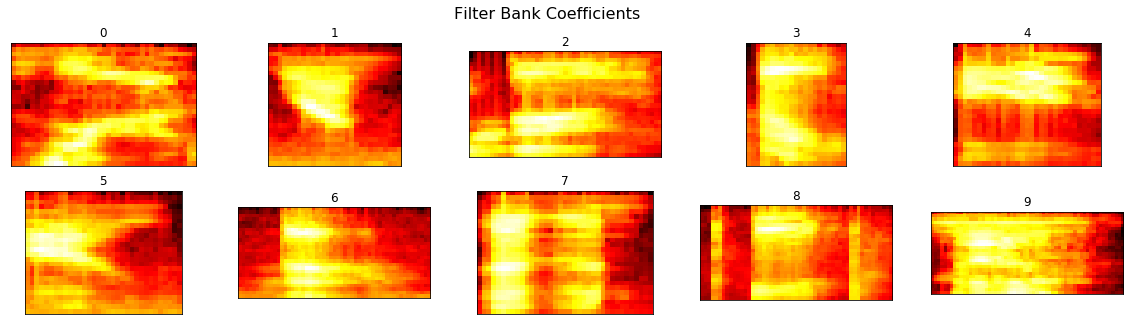

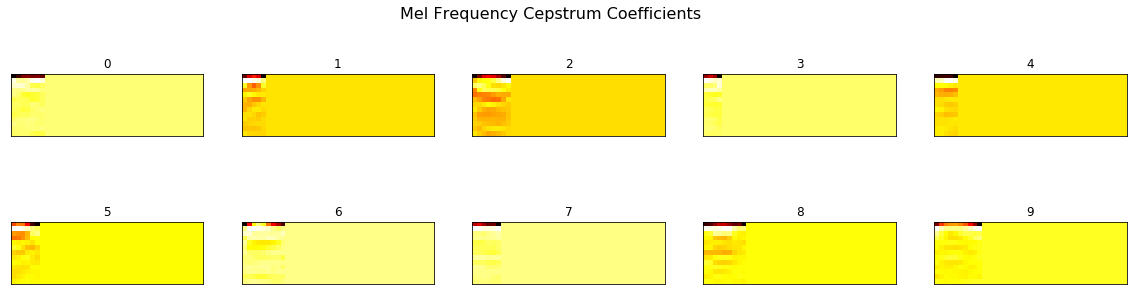

<Figure size 432x288 with 0 Axes>

In [211]:
plot_signals(signals)
plt.show()
    
plot_fft(fft)
plt.show()
    
plot_fbank(fbank)
plt.show()
    
plot_mfccs(mfccs)
plt.show()

plt.savefig('plot.pdf')

### Splitting dataset and finding mfccs
1. extract features and label for all wav files
2. design a multilayer perceptron using cnn

In [212]:
class Config:
    def  __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate = 8000, n_classes = 10, learning_rate = 0.0001, max_epochs=50):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.rate = rate
        self.step = int(rate/10)
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs


In [213]:
# creating a fuction to extract labels and data 
# and split it into training and test datasets
df1_test = df.loc[df.speaker=='nicolas']
df2_train = df.loc[df.speaker!='nicolas']
df2_train 

,Digit,length (sec),speaker
3_yweweler_14.wav,3,0.305750,yweweler
4_yweweler_38.wav,4,0.383125,yweweler
3_yweweler_28.wav,3,0.284000,yweweler
4_yweweler_10.wav,4,0.362250,yweweler
8_rach_5.wav,8,2.000000,rach
...,...,...,...
3_yweweler_31.wav,3,0.212125,yweweler
7_theo_47.wav,7,0.390250,theo
4_yweweler_21.wav,4,0.342500,yweweler
3_yweweler_19.wav,3,0.395625,yweweler


In [214]:
def getmfcc(y, max_pad_len=40):
    mask = envelope(y, 8000, 0.001)
    y = y[mask]
    mfcc = librosa.feature.mfcc(y, sr=8000 ,n_mfcc=13)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width>=0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:,0:40]
    return mfcc

def get_data(x):
    y = []
    mfccs = []
    for c in x.index:
        signal, rate = librosa.load('../Data/'+c,sr = None)
        y.append(x.Digit[c])
        mfccs.append(getmfcc(signal))
    return np.asarray(mfccs), to_categorical(y)

In [215]:
mfccs_test, y_ts = get_data(df1_test)
X_ts = mfccs_test
X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1],X_ts.shape[2] , 1))

In [216]:
mfccs_train, y_tr = get_data(df2_train)
X_tr = mfccs_train
X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1],X_tr.shape[2] , 1))

In [217]:
mfccs_test.shape # mfcc of each file has the shape (13x20)--> so shape of final 3d array is 500x13x20

(500, 13, 40)

In [218]:
y_ts #label is converted to binary form --> Hence, shape = 500,10 --> 500 data files and 10 digits

print('yts',y_ts.shape)
print('xts',X_ts.shape)

yts (500, 10)
xts (500, 13, 40, 1)


In [219]:
mfccs_train.shape

(1600, 13, 40)

In [220]:
print('ytr',y_tr.shape)
print('xtr',X_tr.shape)

ytr (1600, 10)
xtr (1600, 13, 40, 1)


### Modeling

In [221]:
dimension_1 = X_tr.shape[1]
dimension_2 = X_tr.shape[2]
input_shape = (dimension_1, dimension_2, 1)

In [222]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


def cnn_model(input_shape, num_classes):
# Defining a sequential model    
    model = Sequential()

# Feature Learning Layers  -- Convolution - RELU 1st Block, Minimum of three such blocks is what I go with a rule of thumb
    
    # This is the input layer, so input shape has to be given, this layer uses 32 feature maps of size 2x2
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    # Convolution - RELU 2nd Block. This layer uses 64 feature maps of size 3x3
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    # Convolution - RELU 3rd Block, using 128 feature maps, size 5x5
    model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    
    # I tried using same kernel size with different number of feature maps but this is the combination with which I got the
    # best results in limited amount of time

    # Max Pooling layer with pooling matrix of size 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening the vector to input it into the model
    model.add(Flatten())

# Classification layers    

    # First hidden layer has 128 Neurons and it also represents the dimension of its output space
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Second hidden layer has 64 Neurons and it is the dimension of its output space.
    # Most of the problems are solved using 1 to 2 hidden layers,there are very few situations 
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # This is the final layer in the model, it has num_classes number of neurons which is 10 in our case. Activation function 
    # used here is softmax as here it will classify the input into on of the 10 output classes
    model.add(Dense(num_classes, activation='softmax'))
    
    # Loss function used is categorical_crossentropy as it is a multiclass-classification problem 
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

    return model


In [223]:
model = cnn_model(input_shape, 10)

In [224]:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,  patience=7) 
mc = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1,save_best_only=False,mode='max')

history= model.fit(X_tr, y_tr ,epochs=20, callbacks=[es,mc], batch_size=64,verbose=1, validation_split=0.2)

Train on 1280 samples, validate on 320 samples
Epoch 1/20
1280/1280 [==============================] - 8s 6ms/step - loss: 1.9049 - accuracy: 0.4289 - val_loss: 2.3149 - val_accuracy: 0.3344

Epoch 00001: saving model to model.h5
Epoch 2/20
1280/1280 [==============================] - 5s 4ms/step - loss: 0.8508 - accuracy: 0.7414 - val_loss: 1.2647 - val_accuracy: 0.6250

Epoch 00002: saving model to model.h5
Epoch 3/20
1280/1280 [==============================] - 6s 5ms/step - loss: 0.5036 - accuracy: 0.8578 - val_loss: 1.0322 - val_accuracy: 0.7250

Epoch 00003: saving model to model.h5
Epoch 4/20
1280/1280 [==============================] - 6s 4ms/step - loss: 0.3798 - accuracy: 0.8977 - val_loss: 0.9718 - val_accuracy: 0.7500

Epoch 00004: saving model to model.h5
Epoch 5/20
1280/1280 [==============================] - 6s 4ms/step - loss: 0.3232 - accuracy: 0.9195 - val_loss: 0.7943 - val_accuracy: 0.8188

Epoch 00005: saving model to model.h5
Epoch 6/20
1280/1280 [================

In [225]:
def predict(X, y):
    # Loading the saved model
    trained_model = keras.models.load_model('model.h5')
    # Making the predictions
    predictions = trained_model.predict_classes(X)
    
    print(classification_report(y, to_categorical(predictions)))

# Predicting the Test dataset and printing the classification report
predict(X_ts,y_ts)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.27      0.16      0.20        50
           2       0.72      0.36      0.48        50
           3       0.25      0.02      0.04        50
           4       0.00      0.00      0.00        50
           5       0.31      0.86      0.46        50
           6       0.10      0.32      0.15        50
           7       1.00      0.02      0.04        50
           8       0.35      0.88      0.51        50
           9       0.25      0.08      0.12        50

   micro avg       0.27      0.27      0.27       500
   macro avg       0.33      0.27      0.20       500
weighted avg       0.33      0.27      0.20       500
 samples avg       0.27      0.27      0.27       500



In [226]:
model.evaluate(X_ts,y_ts)

500/500 [==============================] - 1s 1ms/step


[2.721542236328125, 0.27000001072883606]

In [227]:
def predict_user_input(x):
    #x = x[::3]
    mfcc_comp = getmfcc(x)
    #mfcc_comp = numpy.asfortranarray(mfcc_comp)
    #pad_width = 20 - mfcc_comp.shape[1]
    #mfcc_comp = np.pad(mfcc_comp, pad_width=((0, 0), (0, pad_width)), mode='constant')
    recording = np.asarray(mfcc_comp)
    recording = recording.reshape((1, mfcc_comp.shape[0],mfcc_comp.shape[1], 1))
    trained_model = keras.models.load_model('model.h5')
    predictions = trained_model.predict_classes(recording)
    print('Model Prediction: {}'.format(predictions[0]))

In [269]:
samplerate = 8000  
duration = 2
filename = 'rec.wav'
print("begin")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate, channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

begin
end


In [270]:
x, sr = librosa.load('rec.wav', mono=True, sr=None)
s = librosa.resample(x, sr, 8000)
mask = envelope(s, sr, 0.001)
s = s[mask]
ipd.Audio(s,rate=8000)

In [271]:
predict_user_input(s)

Model Prediction: 9


In [196]:
# record audio
i = input()
samplerate = 8000  
duration = 2
filename = i+'.wav'
print("begin")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate, channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)
x, sr = librosa.load(filename, mono=True, sr=None)
s = librosa.resample(x, sr, 8000)
mask = envelope(s, sr, 0.001)
s = s[mask]
ipd.Audio(s,rate=8000)

9_rach_10
begin
end
